In [35]:
import requests
import json
import gravis as gv
import bs4
import requests
from xmltodict import parse
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
from itertools import combinations
import zipfile
import librosa
import io
import os
import glob
from sklearn.naive_bayes import GaussianNB
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# HOMEWORK 4
## Q1 (Author attribution)

For this question we are going to use two novels:
- [Jayne Eyre](https://www.gutenberg.org/ebooks/1260) by Charlotte Bronte, and
- [Pride and Prejudice](https://www.gutenberg.org/ebooks/1342) by Jane Austen.

1. Get the novels' plain text versions and remove all the parts which do not belong to the novels.
2. Using NLTK's sentence tokenizers, tokenize each novel.
3. Label sentences by 0 or 1 depending on whether the sentence is written by Austen or Bronte, and then merge the two sentence data sets.
4. Vectorize the merged sentence dataset. (Tell the vectorizer to remove all stop words.)
5. Split the vectorized sentences and labels as train and test. Use the 25% of the data as test.
6. Train a logistic regression model on the train subset.
7. Using the model you trained, predict labels on the test set, and then construct a confusion matrix.
8. Can your model distinguish sentences written by Bronte or Austen? Analyze.

## Q1-ANSWER

For this question, we are gonna get the novels' plain text. As there are two novels, we can define a function for pulling process:

In [2]:
def get_gutenberg_text(url):
    response = requests.get(url)
    soup = bs4.BeautifulSoup(response.content, "html.parser")
    text = soup.text
    response.close()
    return text

In [3]:

jane_eyre = get_gutenberg_text("https://www.gutenberg.org/cache/epub/1260/pg1260.txt")
pride_pre = get_gutenberg_text("https://www.gutenberg.org/cache/epub/1342/pg1342.txt")

Now, as we only need the plain novel, we take only necessary parts:

In [4]:
je_plain = jane_eyre.split('_April_ 13_th_, 1848.')[1].split('*** END OF THE PROJECT GUTENBERG EBOOK JANE EYRE: AN AUTOBIOGRAPHY ***')[0]

In [5]:
pride_pre_plain = 'It is a truth universally acknowledged '+pride_pre.split('It is a truth universally acknowledged')[1].split('*** END OF THE PROJECT GUTENBERG EBOOK PRIDE AND PREJUDICE ***')[0]

Now, cleaned unnecessary signs etc

In [6]:
je_cleaned = re.sub(r'\[([^\]]+)\]|\r|\n','', je_plain.lower())
pride_pre_cleaned = re.sub(r'\[([^\]]+)\]|\r|\n','', pride_pre_plain.lower())


Then tokenize each novel by sentence:

In [7]:
je_tokenized = sent_tokenize(je_cleaned)
pride_tokenized = sent_tokenize(pride_pre_cleaned)


Merged all sentences in idct so that sentences belongs to pride and prejudice have value 0, jane eyre will be 1, then split the data as a train and test with size 0.25 :

In [8]:
sent_all = {i: 0 if i in pride_tokenized else 1 for i in set(pride_tokenized + je_tokenized)}
texts = list(sent_all.keys())
labels = list(sent_all.values())

In [9]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.25, random_state=42)

Removed stopwords, vectorize and train a logistic regression model for classification. 

Then, make prediction with test set and see the accuracy:

In [10]:
stop_words = set(stopwords.words('english'))
vectorizer = CountVectorizer(stop_words=stop_words)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8473214285714286


Now, create a confusion matrix and analyse the result:

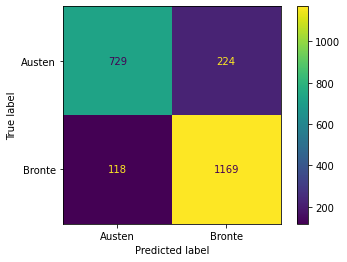

In [11]:
cm = metrics.confusion_matrix(y_test,y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Austen', 'Bronte'])
cm_display.plot()
plt.show()

As we can see above, from confusion matrix, the model predict approximately 80% of Austen's sentences and 90% of Bronte's sentences correctly. Thus, we can say that our model can distinguish most of the sentence's owners correctly. I believe that by making manipulations on text data a bit more, we can achieve higher accuracy scores.

## Q2 (Voice recognition)

For this question we are going to use the [Axiom voice recognition dataset](https://zenodo.org/records/1218979). The voice data contains data for 73 individuals. Since the dataset is fairly large, do not commit your local copy to github.

1. Build machine learning models that distinguish these individuals.
2. Test your model(s) and calculate their accuracies.
3. Construct and display confusion matrix or matrices.

## Q2-ANSWER
I pulled the related data, then used Gaussian Naive Bayes classifier.

In [28]:
try:
    response_vd = requests.get("https://zenodo.org/api/records/1218979/files")
    response_vd.raise_for_status()  # Raises an exception for HTTP errors (4xx or 5xx)
    
    # Verify content and handle JSON parsing
    if response_vd.ok:
        json_content = response_vd.json()
        # Process the JSON data
        
except requests.HTTPError as http_err:
    print(f"HTTP error occurred: {http_err}")
    
except ValueError as val_err:
    print(f"Value error while decoding JSON: {val_err}")
    
except Exception as err:
    print(f"An error occurred: {err}")


In [29]:
audio_urls = json_content['entries'][0]['links']['content']
audio_urls

'https://zenodo.org/api/records/1218979/files/AXIOM%20audio.zip/content'

In [30]:
response = requests.get(audio_urls)

if response.status_code == 200:
    # create a folder object to extract files
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        # extract the content
        zip_ref.extractall('audio_files')
        print("ZIP succesfully downloaded")
else:
    print("http error:", response.status_code)

ZIP succesfully downloaded


In [31]:
dosya_listesi = os.listdir('audio_files')

print("All:")
for dosya in dosya_listesi:
    print(dosya)

All:
AXIOM audio
__MACOSX


In [32]:
audio_directory = os.path.join('audio_files', 'AXIOM audio')


Took all files with wav extension:

In [33]:
wav_files = glob.glob(os.path.join(audio_directory, '**/*.wav'), recursive=True)

Stored person id's in label list:

In [34]:
file_names = []
label = []

# Extracting and storing the required information
for wav_file in wav_files:
    file_name = os.path.basename(wav_file)  # Extract the file name
    file_names.append(file_name)  # Store the file name
    
    # Extracting the first element between the first two underscores
    first_element = file_name.split('_')[1]  # Splitting the file name by underscores and extracting the second element
    label.append(first_element)

Accuracy: 82.42%


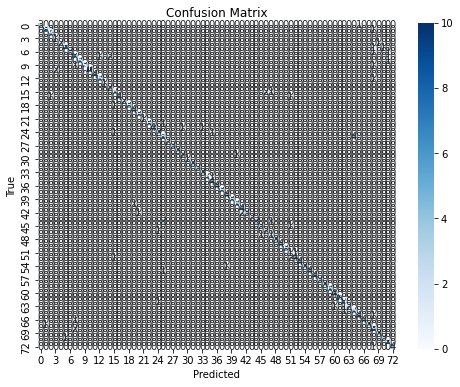

In [36]:
x=wav_files
# Function to extract features from audio files
def extract_features(file_path):
    # Load audio file
    audio_data, _ = librosa.load(file_path, sr=None)
    # Extract MFCC (Mel-frequency cepstral coefficients) as features
    mfccs = librosa.feature.mfcc(y=audio_data, sr=44100, n_mfcc=20)
    # Return the mean value of MFCC coefficients as features
    return np.mean(mfccs.T, axis=0)

# Extracting features and labels
features = []
labels = label  # label contains labels

for file_path in x:
    file_features = extract_features(file_path)
    features.append(file_features)

# Convert lists to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Initialize the model (Gaussian Naive Bayes classifier)
model = GaussianNB()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Q3 (City hopping)

For this question we are going to use [Open Flight Data](https://openflights.org/data.php).

1. Pull the data on airports and routes. Clean it and put the correct names on columns. Read the [documentation on the data](https://openflights.org/data.php).
2. Merge the route dataset and the airport dataset so the combined version has route source and target airports has full airport names and cities instead of airport codes.
3. Construct a graph where each node is a city, and two cities are connected by an edge if there is a flight between these cities.
4. Find the flight routes with the minimal number of stops for the following source and target cities. For example, a route that has the minimal number of connections/stops from Antalya to Deer Lake (Canada) is Antalya, London, Halifax, Deer Lake.
   - From Adana (Turkey) to Auckland (New Zealand)
   - From Ankara (Turkey) to Kona (Hawaii, USA)
   - From Sydney (Australia) to Churchhill (Canada)
5. Using the networkx's implementation of the [Page Rank Algorithm](https://en.wikipedia.org/wiki/PageRank) find the top 10 cities that are important for the global flight network.

## Q3-ANSWER

For this question, first we are gonna pull the data on airports and routes,clean it and put the correct names on columns:

In [2]:

airports_link = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
routes_link = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat"

airports_colnames=["Airport_ID","City","Country","IATA","ICAO","Latitude","Longitude","Altitude","Timezone","DST","Tz_database_timezone","Type","Source"]
routes_colnames=["Airline","Airline_ID","Source_airport","Source_airport_ID","Destination_airport","Destination_airport_ID","Codeshare","Stops","Equipment"]

airport_df = pd.read_csv(airports_link, names = airports_colnames)
routes_df = pd.read_csv(routes_link, names = routes_colnames)


dropped unnecessary columns, take necessaary columns:

In [3]:
routes_df.drop(['Airline','Airline_ID','Codeshare','Equipment'],axis=1,inplace=True)

In [4]:
routes_df.head()

,Source_airport,Source_airport_ID,Destination_airport,Destination_airport_ID,Stops
0,AER,2965,KZN,2990,0
1,ASF,2966,KZN,2990,0
2,ASF,2966,MRV,2962,0
3,CEK,2968,KZN,2990,0
4,CEK,2968,OVB,4078,0


In [5]:
airport_df=airport_df[['Airport_ID', 'City', 'Country', 'IATA', 'ICAO']]
airport_df

,Airport_ID,City,Country,IATA,ICAO
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY
...,...,...,...,...,...
14106,Rogachyovo Air Base,Belaya,Russia,\N,ULDA
14107,Ulan-Ude East Airport,Ulan Ude,Russia,\N,XIUW
14108,Krechevitsy Air Base,Novgorod,Russia,\N,ULLK
14109,Desierto de Atacama Airport,Copiapo,Chile,CPO,SCAT


In [6]:
airport_df['IATA'].isna().sum()

0

In [7]:
routes_df[routes_df['Source_airport'].str.len() == 4]['Source_airport'].count()

0

In [8]:
routes_df[routes_df['Destination_airport'].str.len() == 4]['Destination_airport'].count()

0

First, we will merge routes_df and airport_df on source airport in roues_df and IATA in airport_df. We know that according to documentation, some of airports coded with IATA(3 letters),and some of them are coded with ICAO(4 letter) but as all of them has IATA, i prefer to merge on IATA:

In [9]:
routes_df = routes_df.merge(airport_df, how="left", left_on="Source_airport", right_on="IATA")

In [10]:
routes_df

,Source_airport,Source_airport_ID,Destination_airport,Destination_airport_ID,Stops,Airport_ID,City,Country,IATA,ICAO
0,AER,2965,KZN,2990,0,Sochi International Airport,Sochi,Russia,AER,URSS
1,ASF,2966,KZN,2990,0,Astrakhan Airport,Astrakhan,Russia,ASF,URWA
2,ASF,2966,MRV,2962,0,Astrakhan Airport,Astrakhan,Russia,ASF,URWA
3,CEK,2968,KZN,2990,0,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,CEK,USCC
4,CEK,2968,OVB,4078,0,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,CEK,USCC
...,...,...,...,...,...,...,...,...,...,...
67658,WYA,6334,ADL,3341,0,Whyalla Airport,Whyalla,Australia,WYA,YWHA
67659,DME,4029,FRU,2912,0,Domodedovo International Airport,Moscow,Russia,DME,UUDD
67660,FRU,2912,DME,4029,0,Manas International Airport,Bishkek,Kyrgyzstan,FRU,UAFM
67661,FRU,2912,OSS,2913,0,Manas International Airport,Bishkek,Kyrgyzstan,FRU,UAFM


There are some airports/codes which do not in airports_df, so we will delete that rows:

In [11]:
routes_df[routes_df['Airport_ID'].isnull()]

,Source_airport,Source_airport_ID,Destination_airport,Destination_airport_ID,Stops,Airport_ID,City,Country,IATA,ICAO
175,AOS,7167,KZB,7176,0,NaN,NaN,NaN,NaN,NaN
176,KKB,7168,SYB,7173,0,NaN,NaN,NaN,NaN,NaN
178,KOZ,7164,ORI,7165,0,NaN,NaN,NaN,NaN,NaN
179,SYB,7173,KPR,7172,0,NaN,NaN,NaN,NaN,NaN
270,CGA,7144,HYL,7145,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
67471,MLH,\N,QSF,6492,0,NaN,NaN,NaN,NaN,NaN
67537,EAR,6129,DEN,3751,0,NaN,NaN,NaN,NaN,NaN
67542,IGM,6132,LAX,3484,0,NaN,NaN,NaN,NaN,NaN
67543,IGM,6132,PGA,4124,0,NaN,NaN,NaN,NaN,NaN


In [12]:
airport_df[airport_df['IATA'] =='AOS'] # they are not in airports df

,Airport_ID,City,Country,IATA,ICAO


In [13]:
routes_df = routes_df[~routes_df['Airport_ID'].isnull()]

In [14]:
routes_df

,Source_airport,Source_airport_ID,Destination_airport,Destination_airport_ID,Stops,Airport_ID,City,Country,IATA,ICAO
0,AER,2965,KZN,2990,0,Sochi International Airport,Sochi,Russia,AER,URSS
1,ASF,2966,KZN,2990,0,Astrakhan Airport,Astrakhan,Russia,ASF,URWA
2,ASF,2966,MRV,2962,0,Astrakhan Airport,Astrakhan,Russia,ASF,URWA
3,CEK,2968,KZN,2990,0,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,CEK,USCC
4,CEK,2968,OVB,4078,0,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,CEK,USCC
...,...,...,...,...,...,...,...,...,...,...
67658,WYA,6334,ADL,3341,0,Whyalla Airport,Whyalla,Australia,WYA,YWHA
67659,DME,4029,FRU,2912,0,Domodedovo International Airport,Moscow,Russia,DME,UUDD
67660,FRU,2912,DME,4029,0,Manas International Airport,Bishkek,Kyrgyzstan,FRU,UAFM
67661,FRU,2912,OSS,2913,0,Manas International Airport,Bishkek,Kyrgyzstan,FRU,UAFM


Now, we will do the same thing for destination airport:

In [15]:
routes_df = routes_df.merge(airport_df, how="left", left_on="Destination_airport", right_on="IATA")
routes_df

,Source_airport,Source_airport_ID,Destination_airport,Destination_airport_ID,Stops,Airport_ID_x,City_x,Country_x,IATA_x,ICAO_x,Airport_ID_y,City_y,Country_y,IATA_y,ICAO_y
0,AER,2965,KZN,2990,0,Sochi International Airport,Sochi,Russia,AER,URSS,Kazan International Airport,Kazan,Russia,KZN,UWKD
1,ASF,2966,KZN,2990,0,Astrakhan Airport,Astrakhan,Russia,ASF,URWA,Kazan International Airport,Kazan,Russia,KZN,UWKD
2,ASF,2966,MRV,2962,0,Astrakhan Airport,Astrakhan,Russia,ASF,URWA,Mineralnyye Vody Airport,Mineralnye Vody,Russia,MRV,URMM
3,CEK,2968,KZN,2990,0,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,CEK,USCC,Kazan International Airport,Kazan,Russia,KZN,UWKD
4,CEK,2968,OVB,4078,0,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,CEK,USCC,Tolmachevo Airport,Novosibirsk,Russia,OVB,UNNT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67252,WYA,6334,ADL,3341,0,Whyalla Airport,Whyalla,Australia,WYA,YWHA,Adelaide International Airport,Adelaide,Australia,ADL,YPAD
67253,DME,4029,FRU,2912,0,Domodedovo International Airport,Moscow,Russia,DME,UUDD,Manas International Airport,Bishkek,Kyrgyzstan,FRU,UAFM
67254,FRU,2912,DME,4029,0,Manas International Airport,Bishkek,Kyrgyzstan,FRU,UAFM,Domodedovo International Airport,Moscow,Russia,DME,UUDD
67255,FRU,2912,OSS,2913,0,Manas International Airport,Bishkek,Kyrgyzstan,FRU,UAFM,Osh Airport,Osh,Kyrgyzstan,OSS,UAFO


In [16]:
airport_df[airport_df['Airport_ID']=='FRU']

,Airport_ID,City,Country,IATA,ICAO


In [17]:
routes_df = routes_df[~routes_df['Airport_ID_y'].isnull()]

We will take only necessary columns, and rename them:

In [18]:
final_df = routes_df[['Airport_ID_x', 'City_x', 'Airport_ID_y', 'City_y']]
final_df

,Airport_ID_x,City_x,Airport_ID_y,City_y
0,Sochi International Airport,Sochi,Kazan International Airport,Kazan
1,Astrakhan Airport,Astrakhan,Kazan International Airport,Kazan
2,Astrakhan Airport,Astrakhan,Mineralnyye Vody Airport,Mineralnye Vody
3,Chelyabinsk Balandino Airport,Chelyabinsk,Kazan International Airport,Kazan
4,Chelyabinsk Balandino Airport,Chelyabinsk,Tolmachevo Airport,Novosibirsk
...,...,...,...,...
67252,Whyalla Airport,Whyalla,Adelaide International Airport,Adelaide
67253,Domodedovo International Airport,Moscow,Manas International Airport,Bishkek
67254,Manas International Airport,Bishkek,Domodedovo International Airport,Moscow
67255,Manas International Airport,Bishkek,Osh Airport,Osh


In [19]:
final_df.rename(columns = {'Airport_ID_x':'Source_airport','City_x':'Source_City','Airport_ID_y':'Destination_airport','City_y':'Destination_City'},inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_10636\3596183498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.rename(columns = {'Airport_ID_x':'Source_airport','City_x':'Source_City','Airport_ID_y':'Destination_airport','City_y':'Destination_City'},inplace=True)


In [20]:
final_df.isnull().sum()

Source_airport         0
Source_City            2
Destination_airport    0
Destination_City       2
dtype: int64

As we will create graph, based on cities, we will drop empty rows:

In [21]:
final_df=final_df.drop(final_df[final_df['Source_City'].isnull()].index)
final_df=final_df.drop(final_df[final_df['Destination_City'].isnull()].index)


In [22]:
final_df.isna().sum()

Source_airport         0
Source_City            0
Destination_airport    0
Destination_City       0
dtype: int64

Now, first we will create edges, and then define the graph:

In [23]:
edges = list(zip(final_df['Source_City'], final_df['Destination_City']))

In [24]:
G_city = nx.from_edgelist(set(edges))

We will find the flight routes with the minimal number of stops for the following source and target cities:

* From Adana (Turkey) to Auckland (New Zealand)
* From Ankara (Turkey) to Kona (Hawaii, USA)
* From Sydney (Australia) to Churchhill (Canada)

Generally speaking, we will find a shortest path in the graph. Thus, i defined a function for this process:

In [25]:
def find_shortest_path(g,s,t):
    shortest_path = nx.shortest_path(g, source=s, target=t)
    return shortest_path

In [26]:
paths=[['Adana','Auckland'],['Ankara','Kona'],['Sydney','Churchill']]
shortest_paths = [find_shortest_path(G_city,pair[0],pair[1]) for pair in paths]
for path, pair in zip(shortest_paths, paths):
    source, target = pair[0], pair[1]
    print(f"Shortest path between  {source} and {target} : {path}")

Shortest path between  Adana and Auckland : ['Adana', 'Jeddah', 'Los Angeles', 'Auckland']
Shortest path between  Ankara and Kona : ['Ankara', 'Munich', 'Los Angeles', 'Kona']
Shortest path between  Sydney and Churchill : ['Sydney', 'Toronto', 'Winnipeg', 'Churchill']


Finally, we will find the top 10 cities that are important for the global flight network, by using the Page Rank Algorithm :

In [27]:
pagerank = nx.pagerank(G_city)

top_10_cities = sorted(pagerank, key=pagerank.get, reverse=True)[:10]# Sort the cities based on their PageRank scores and get the top 10 cities

print("Top 10 cities important for the global flight network:")# Display the top 10 cities
for i, city in enumerate(top_10_cities, start=1):
    print(f"{i}. {city}: PageRank Score - {pagerank[city]}")

Top 10 cities important for the global flight network:
1. London: PageRank Score - 0.006337402865762117
2. Moscow: PageRank Score - 0.0061763921469385205
3. Paris: PageRank Score - 0.005569215499026185
4. Istanbul: PageRank Score - 0.005328465704670044
5. Atlanta: PageRank Score - 0.004694651978335464
6. Chicago: PageRank Score - 0.004628672052045807
7. Denver: PageRank Score - 0.004457030729019319
8. Dallas-Fort Worth: PageRank Score - 0.004439269834907623
9. Beijing: PageRank Score - 0.004412097366113179
10. Amsterdam: PageRank Score - 0.0043333666753892185
